In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Rotate a 2d vector by a given angle degrees
def rotate_vector(vector, angle):
    angle = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return rotation_matrix @ vector

# Take a detection in world frame and transform to robot frame
def calculate_detection(robot_pos, person_pos):
    # First compute person's position in robot's frame
    person_pos  = np.array([person_pos[0] - robot_pos[0], person_pos[1] - robot_pos[1]])

    # Then rotate into robots heading frame (x is forward, y is left)
    person_pos = rotate_vector(person_pos, -robot_pos[2])
    
    return person_pos
    
# Take detection in robot frame and transform to world frame
def detection_to_world_frame(robot_pos, detection):
    # Rotate the detection into the world frame
    detection = rotate_vector(detection, robot_pos[2])
    
    # Translate the detection into the world frame
    detection = detection + robot_pos[0:2]
    
    return detection

# True positions of the robots (x, y, orientation)
robot_jeep_pos = np.array([-0.5, 1., 45.]) # Assuming Jeep is at the origin facing 45 degrees
robot_wolf_pos = np.array([10., 0., -45.]) # Assuming Wolf is 10 units to the right of Jeep facing -45 degrees

# Sample positions of the person in front of the robots
person_positions = [np.array([5., 2.]), np.array([6., 4.]), np.array([7., 6.]), np.array([8., 8.]), np.array([9., 10.]), np.array([2., 12.]), np.array([8., 3.]),
                    np.array([7., 2.]), np.array([6., 1.]), np.array([5., 0.]), np.array([4., -1.]), np.array([3., -2.]), np.array([2., -3.]), np.array([1., -4.]), np.array([0., -5.])]

# Simulate detections for each position of the person
jeep_detections = [calculate_detection(robot_jeep_pos, pos) for pos in person_positions]
wolf_detections = [calculate_detection(robot_wolf_pos, pos) for pos in person_positions]

# Test the transformation back to world frame
for person_det, jeep_det in zip(person_positions, jeep_detections):
    jeep_det = calculate_detection(robot_jeep_pos, person_det)
    jeep_world = detection_to_world_frame(robot_jeep_pos, jeep_det)
    wolf_det = calculate_detection(robot_wolf_pos, person_det)
    wolf_world = detection_to_world_frame(robot_wolf_pos, wolf_det)
    print("Person world: ", person_det, "\n Person jeep: ", jeep_det, "\n", "Person world from jeep: ", jeep_world)
    print("Person world: ", person_det, "\n Person wolf: ", wolf_det, "\n", "Person world from wolf: ", wolf_world, "\n")


Person world:  [5. 2.] 
 Person jeep:  [ 4.59619408 -3.18198052] 
 Person world from jeep:  [5. 2.]
Person world:  [5. 2.] 
 Person wolf:  [-4.94974747 -2.12132034] 
 Person world from wolf:  [5. 2.] 

Person world:  [6. 4.] 
 Person jeep:  [ 6.71751442 -2.47487373] 
 Person world from jeep:  [6. 4.]
Person world:  [6. 4.] 
 Person wolf:  [-5.65685425e+00  4.44089210e-16] 
 Person world from wolf:  [6. 4.] 

Person world:  [7. 6.] 
 Person jeep:  [ 8.83883476 -1.76776695] 
 Person world from jeep:  [7. 6.]
Person world:  [7. 6.] 
 Person wolf:  [-6.36396103  2.12132034] 
 Person world from wolf:  [7. 6.] 

Person world:  [8. 8.] 
 Person jeep:  [10.96015511 -1.06066017] 
 Person world from jeep:  [8. 8.]
Person world:  [8. 8.] 
 Person wolf:  [-7.07106781  4.24264069] 
 Person world from wolf:  [8. 8.] 

Person world:  [ 9. 10.] 
 Person jeep:  [13.08147545 -0.35355339] 
 Person world from jeep:  [ 9. 10.]
Person world:  [ 9. 10.] 
 Person wolf:  [-7.77817459  6.36396103] 
 Person worl

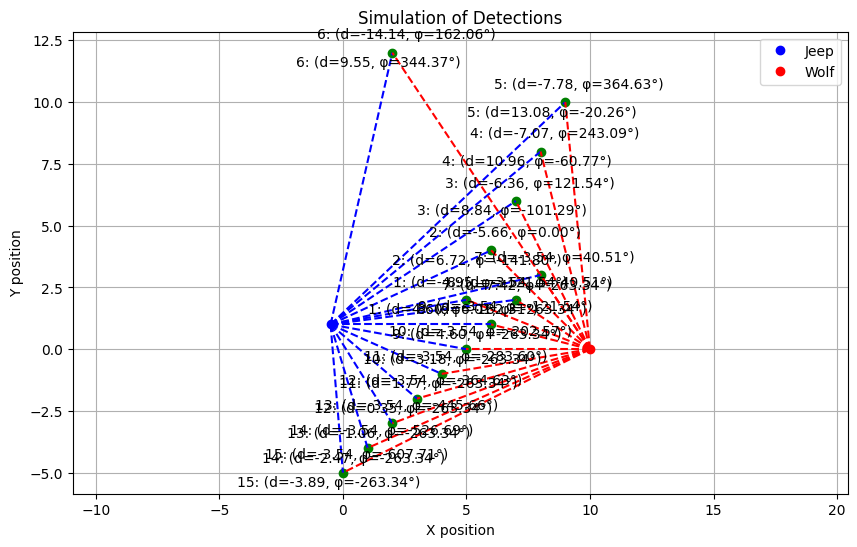

In [47]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot the robots
plt.plot(robot_jeep_pos[0], robot_jeep_pos[1], 'bo', label='Jeep')
plt.plot(robot_wolf_pos[0], robot_wolf_pos[1], 'ro', label='Wolf')

# Plot the person's positions
for pos in person_positions:
    plt.plot(pos[0], pos[1], 'go')

# Annotate detections from Jeep
for i, (r, b) in enumerate(jeep_detections):
    plt.annotate(f'{i+1}: (d={r:.2f}, φ={np.degrees(b):.2f}°)',
                 (person_positions[i][0], person_positions[i][1]),
                 textcoords="offset points", xytext=(-10,-10), ha='center')

# Annotate detections from Wolf
for i, (r, b) in enumerate(wolf_detections):
    plt.annotate(f'{i+1}: (d={r:.2f}, φ={np.degrees(b):.2f}°)',
                 (person_positions[i][0], person_positions[i][1]),
                 textcoords="offset points", xytext=(10,10), ha='center')

# Draw lines for better visualization of detections
for pos in person_positions:
    plt.plot([robot_jeep_pos[0], pos[0]], [robot_jeep_pos[1], pos[1]], 'b--')
    plt.plot([robot_wolf_pos[0], pos[0]], [robot_wolf_pos[1], pos[1]], 'r--')

plt.axis('equal')
plt.legend()
plt.grid(True)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Simulation of Detections')
plt.show()

In [44]:
# The error function that calculates the difference between the observed and predicted measurements
def error_function(hidden_variables, detections_jeep, detections_wolf):
    jeep_pos, wolf_pos= hidden_variables[0:3], hidden_variables[3:6]
    errors = []
    
    for det_jeep, det_wolf in zip(detections_jeep, detections_wolf):
        # Convert the detections (x,y robot frame) to world frame using the hidden variables
        det_jeep_global = detection_to_world_frame(jeep_pos, det_jeep)
        det_wolf_global = detection_to_world_frame(wolf_pos, det_wolf)
        
        # The error is the distance between the two predicted positions
        error_x = det_jeep_global[0] - det_wolf_global[0]
        error_y = det_jeep_global[1] - det_wolf_global[1]
        
        errors.append(error_x**2 + error_y**2)
        
        # Print things for debugging
        # print("Jeep pos: ", jeep_pos)
        # print("Jeep global: ", det_jeep_global)
        # print("Wolf pos: ", wolf_pos)
        # print("Wolf global: ", det_wolf_global)
        # print("Error: ", error_x**2 + error_y**2)
        
    print("Jeep, wolf pos: ", jeep_pos, wolf_pos, "Added error: ", sum(errors))
    return errors


In [19]:
# Load in pickle data and convert from lidar_x,lidar_y -> range,bearing
# Skip if you wanna do just simulated data
# import pickle
# file = open('data.pickle', 'rb')

# # dump information to that file
# data = pickle.load(file)

# Convert to x,y to range bearing
# for i in range(len(jeep_detections)):
#     range_jeep = np.sqrt(jeep_detections[i][0] ** 2 + jeep_detections[i][1] ** 2)
#     bearing_jeep = np.arctan2(jeep_detections[i][0],jeep_detections[i][1])

#     range_wolf = np.sqrt(wolf_detections[i][0] ** 2 + wolf_detections[i][1]**2)
#     bearing_wolf = np.arctan2(wolf_detections[i][0],wolf_detections[i][1])

#     jeep_detections[i] = (range_jeep,bearing_jeep)
#     wolf_detections[i] = (range_wolf,bearing_wolf)

In [49]:
# Initial guesses for the hidden variables
initial_guess = [-0.4, 0.9, 40., 9.0, -0.4, -39.] # x1, y1, theta1, x2, y2, theta2
# print("Initial guess: ", initial_guess)
# initial_guess = np.concatenate((robot_jeep_pos, robot_wolf_pos))
# print("Initial guess: ", initial_guess)

# Perform least squares optimization
result = least_squares(
    error_function, initial_guess,
    args=(jeep_detections, wolf_detections), method='lm'
)

# The optimized hidden variables
jeep_pos, wolf_pos = result.x[0:3], result.x[3:6]

# Print the optimized hidden variables
print(f'Initial guesses, Jeep: {initial_guess[0:3]} Wolf: {initial_guess[3:6]}')
print(f'True Jeep position: {robot_jeep_pos}')
print(f'Estimated Jeep position: {jeep_pos}')

print(f'True Wolf position: {robot_wolf_pos}')
print(f'Estimated Wolf position: {wolf_pos}')

# True positions of the robots (x, y, orientation)
robot_jeep_pos = np.array([-0.5, 1., 45.]) # Assuming Jeep is at the origin facing 45 degrees
robot_wolf_pos = np.array([10., 0., -45.]) # Assuming Wolf is 10 units to the right of Jeep facing -45 degrees

Jeep, wolf pos:  [-0.4  0.9 40. ] [  9.   -0.4 -39. ] Added error:  48.141431689324435
Jeep, wolf pos:  [-0.4  0.9 40. ] [  9.   -0.4 -39. ] Added error:  48.141431689324435
Jeep, wolf pos:  [-0.4  0.9 40. ] [  9.   -0.4 -39. ] Added error:  48.141431689324435
Jeep, wolf pos:  [-0.39999999  0.9        40.        ] [  9.   -0.4 -39. ] Added error:  48.141431937161755
Jeep, wolf pos:  [-0.4         0.90000001 40.        ] [  9.   -0.4 -39. ] Added error:  48.141431840733425
Jeep, wolf pos:  [-0.4        0.9       40.0000006] [  9.   -0.4 -39. ] Added error:  48.141430156272435
Jeep, wolf pos:  [-0.4  0.9 40. ] [  9.00000013  -0.4        -39.        ] Added error:  48.14142611298486
Jeep, wolf pos:  [-0.4  0.9 40. ] [  9.          -0.39999999 -39.        ] Added error:  48.14143162203155
Jeep, wolf pos:  [-0.4  0.9 40. ] [  9.          -0.4        -38.99999942] Added error:  48.14143480873039
Jeep, wolf pos:  [-0.37300723  1.0736486  41.70931899] [  9.58165251  -0.20474463 -42.80763689] A

In [ ]:
initial_guess = np.concatenate((robot_jeep_pos, robot_wolf_pos))